# Понижение размерности и отбор признаков
## 1.Линейная алгебра

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
from PIL import Image
from io import StringIO, BytesIO

mpl.rcParams['figure.figsize'] = (8,5)

In [3]:
def get_image(url):
    print("making request")
    r = requests.get(url)
    strio = BytesIO(r.content)
    i = Image.open(strio)
    print("got image with size %s"%str(np.array(i).shape))
    return i

making request
got image with size (320, 480, 3)
making request
got image with size (320, 480, 3)


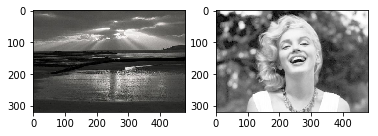

In [4]:
img_links=['http://lykov.tech/data/'+name for name in['bliss.jpg','monroe.jpg']]
imgs = [np.array(get_image(i)) for i in img_links]
plt.subplot(121) 
plt.imshow(imgs[0]) 
plt.subplot(122) 
plt.imshow(imgs[1])

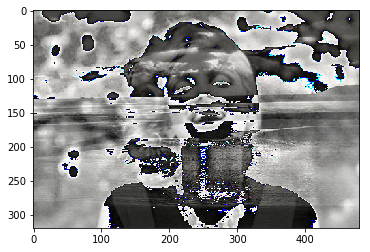

In [5]:

plt.imshow(imgs[0]+imgs[1])

In [6]:

print(type(imgs[1][0,0,0]))

<class 'numpy.uint8'>


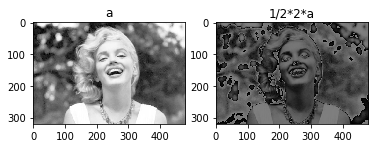

In [7]:
ax=plt.subplot(121)
ax.set_title('a')
ax.imshow(imgs[1]*(2//2))
ax2=plt.subplot(122)
ax2.set_title('1/2*2*a')
plt.imshow(imgs[1]*2//2)

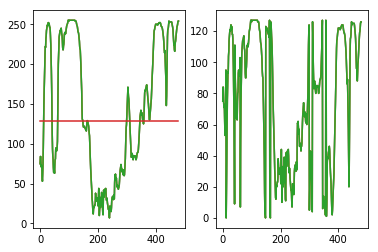

In [8]:
plt.subplot(121)
plt.plot(imgs[1][9]*(2//2))
plt.plot([128]*480)

plt.subplot(122)
plt.plot(imgs[1][9]*2//2)

## 2. PCA

dispersion ratio: 3.200000


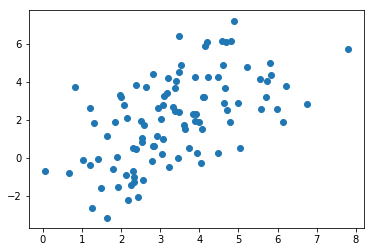

In [9]:
X=np.random.randn(2,100)
X[0]*=2.718
X[0]+=3.2
X[1]-=2.2
ph = np.random.random()*np.pi
c, s = np.cos(ph), np.sin(ph)
R = np.array(((c,-s), (s, c)))
X=np.dot(R,X)
print('dispersion ratio: %f'%(3.2))
plt.scatter(*X)

In [10]:
def PCA_2d(x):
    """
    :param x: a (2,N)-saped numpy array
    :return: a tuple of transformed array and a dict {singular value: vector}
    """
    # translate to center
    X=np.array([l-np.mean(l) for l in x])
    # compute svd
    U,s,V=np.linalg.svd(X)
    print('singular vals ratio: %f'%(max(s)/min(s)))
    lookup={s:vec for s,vec in zip(s,U)}
    E = [lookup[v] for v in sorted(s)]
    print('eigenvectors: %s'%str(E))
    E=np.array(E)
    X_=np.dot(E,X)
    return X_,lookup

singular vals ratio: 2.211148
eigenvectors: [array([-0.8998929 ,  0.43611095]), array([-0.43611095, -0.8998929 ])]


Text(0.5,1,'original')

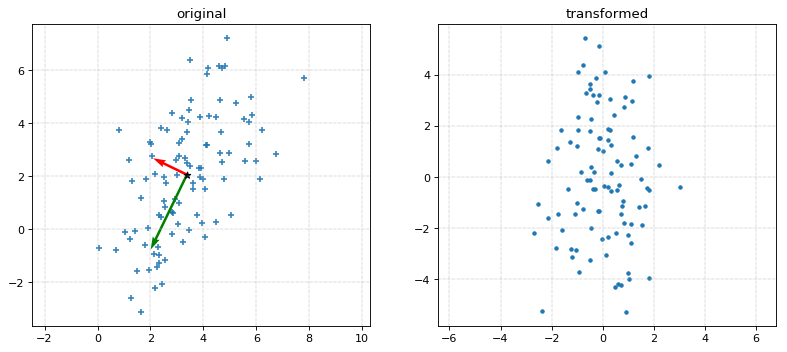

In [11]:
#Делаем PCA
X_,sings=PCA_2d(X)

E = np.array([sings[v] for v in sorted(sings.keys())])
means = np.mean(X,axis=1)

# Оформление графиков
plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax1=plt.subplot(122)
#ax1.bar([1,2],sings.keys())
ax1.scatter(*X_,marker='.')
ax1.set_title('transformed')
ax1.axis('equal')
ax1.grid(True,linewidth=0.4,linestyle='-.')
ax2=plt.subplot(121)
#ax2.scatter(*X_,marker='.')
ax2.scatter(*X,alpha=0.9,marker='+')

ax2.axis('equal')
ax2.grid(True,linewidth=0.4,linestyle='-.')
ax2.quiver(*means,*(E.T*list(sorted(sings.keys()))),scale=100,color=['r','g'])
ax2.scatter(*means,marker='*',color='black')
ax2.set_title('original')

In [12]:

# Проверяем действительно ли базисные вектора - собственные
X_cent=X-means.reshape((-1,1))
W = np.dot(X_cent,X_cent.T)
vecs = np.dot(W,E.T)
print( 'before\n%s\nafter:\n%s'%(E,vecs))
print( 'ratios \n%s'%(np.divide(vecs,E)))
print( 'sqrt ratios \n%s'%(np.sqrt(np.abs(np.divide(vecs,E)))))

before
[[-0.8998929   0.43611095]
 [-0.43611095 -0.8998929 ]]
after:
[[-111.39660548 -263.94523794]
 [  53.98562417 -544.63765106]]
ratios 
[[ 123.78873668 -605.22496609]
 [-123.78873668  605.22496609]]
sqrt ratios 
[[11.12603868 24.60132041]
 [11.12603868 24.60132041]]


## Практический пример

In [13]:
def pca(X,num_components):
    X=np.array([l-np.mean(l) for l in X]) # Вычитаем среднее
    U,s,V=np.linalg.svd(X)                # Находим собственные вектора
    eps=np.sort(s)[-num_components]       # пороговое собственное значение (служебная строчка) 
    E = np.array([vec for val,vec in zip(s,V)
                  if val>eps])            # берем только важные вектора   (с большими собственными значениями)
    X_=np.dot(E,X.T).T                    # Преобразуем данные
    return X_,E

(320, 480)
(320, 480)
max of transformed: 145.890309, min: -161.865880
delta 307.75618889048997


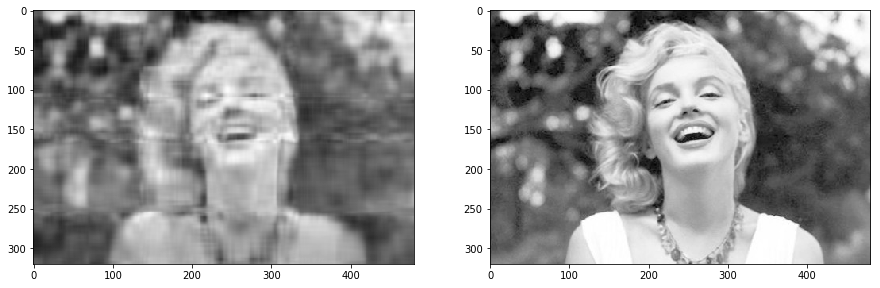

In [14]:
# В изображении 3 канала - усредняем
X  = np.mean(imgs[1],axis=2)
print(X.shape)

# Делаем PCA
T,E = pca(X,15)
# Преобразуем обратно в исходное пространство
reconstr = np.dot(T,E)
print(reconstr.shape)

# Графики
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(reconstr,cmap='gray')
plt.subplot(122)
plt.imshow(X,cmap='gray')

print('max of transformed: %f, min: %f'%(max(reconstr.flatten()),min(reconstr.flatten())))
print('delta',(max(reconstr.flatten())-min(reconstr.flatten())))

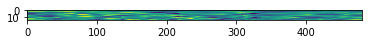

In [15]:

# Выводим матрицу преобразования. Каждая строчка - базисный вектор
plt.imshow(E)

## Бонус: энтропия до и после преобразования

original entropy: 3.0442419084640515
transformed entropy: 2.847174159806836
entropy loss: 0.19706774865721544

data size before 153600 after 4480
compression ratio 34.285714285714285


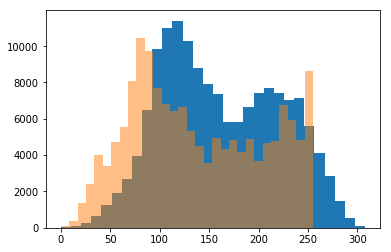

In [16]:
import scipy.stats
def softmax(x):
    return np.power(x,2.1828)/sum(np.power(x,2.1828))
r = reconstr.flatten()
r-=min(r)
o = X.flatten()
dist_transformed = plt.hist(r,bins=30)[0]
dist_orig = plt.hist(o,alpha=0.5,bins=30)[0]
dist_transformed=softmax(dist_transformed)
dist_orig=softmax(dist_orig)

e1 = scipy.stats.entropy(dist_orig)
e2=scipy.stats.entropy(dist_transformed)
print('original entropy:',e1)
print('transformed entropy:',e2)
print('entropy loss:',e1-e2)

print()
print('data size before %i after %i'%(len(o),len(T.flatten())))
print('compression ratio',len(o)/len(T.flatten()))